In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Load data

In [29]:
df = pd.read_csv('data/cycle_hires/sample2016.csv')
df.rename(columns={'date':'start_date'}, inplace=True)
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y %H:%M')
print(df.shape)
df.head()

(1021639, 8)


,rental_id,duration,bike_id,endstation_id,endstation_name,start_date,startstation_id,startstation_name
0,55328088,3.0,2816.0,75.0,"Torrens Street, Angel",2016-06-28 11:53:00,695.0,"Islington Green, Angel"
1,51974713,20.0,11402.0,331.0,"Bunhill Row, Moorgate",2016-03-07 11:45:00,537.0,"Old Montague Street, Whitechapel"
2,54678148,7.0,7923.0,25.0,"Doric Way , Somers Town",2016-06-08 18:21:00,572.0,"Greenland Road, Camden Town"
3,53927118,23.0,7053.0,124.0,"Eaton Square, Belgravia",2016-05-17 08:19:00,671.0,"Parsons Green Station, Parsons Green"
4,59323262,21.0,12336.0,517.0,"Ford Road, Old Ford",2016-10-11 18:16:00,130.0,"Tower Gardens , Tower"


# When do people rent cycles?

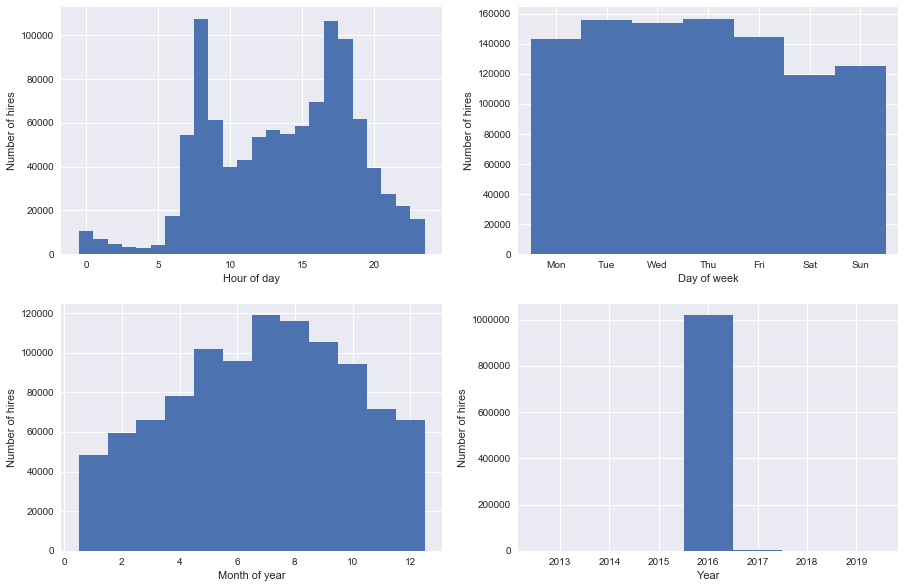

In [30]:
# Distributions of number of hires

plt.figure(figsize=(15,10))

# By hour of day
plt.subplot(221)
plt.hist(df['start_date'].dt.hour, bins=np.arange(0, 25)-0.5)
plt.xlabel('Hour of day')
plt.ylabel('Number of hires')

# By day of week
plt.subplot(222)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['dayofweek'] = df['start_date'].dt.weekday
grouped = df.groupby('dayofweek')['startstation_id'].count()
grouped.index = days
grouped.plot(kind='bar', width=1)
plt.xticks(rotation=0)
plt.xlabel('Day of week')
plt.ylabel('Number of hires')

# By month of year
plt.subplot(223)
plt.hist(df['start_date'].dt.month, bins=np.arange(1,14)-0.5);
plt.xlabel('Month of year')
plt.ylabel('Number of hires')

# By year
plt.subplot(224)
plt.hist(df['start_date'].dt.year, bins=np.arange(2013,2021)-0.5)
plt.xlabel('Year')
plt.ylabel('Number of hires');

The patterns in hourly and dayly rentals suggest that quite a few people use bikes for their commute to work. Let's look into this further.

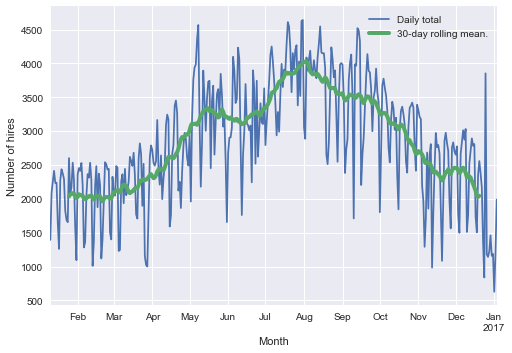

In [32]:
# Weekly rentals through the year

daily = df.set_index('start_date')['rental_id'].resample('d').count()
rolling = daily.rolling(30).mean(center=True)

daily.plot(label='Daily total')
rolling.plot(linewidth=4, label='30-day rolling mean.')
plt.xlabel('Month')
plt.ylabel('Number of hires')
plt.legend();

In [33]:
# Create a dataset with hourly rentals for each day

pivoted = df.pivot_table('rental_id',
               index=df['start_date'].dt.date,
               columns=df['start_date'].dt.hour,
               aggfunc='count',
               fill_value=0
              )
pivoted.head()

start_date,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
start_date,,,,,,,,,,,,,,,,,,,,,
2016-01-10,20,27,14,6,10,6,5,7,22,54,...,164,143,108,80,53,49,40,38,20,13
2016-01-11,7,0,0,2,2,4,30,115,301,180,...,76,88,124,270,274,150,81,60,30,11
2016-01-12,8,5,2,7,8,6,60,195,377,186,...,77,71,125,280,228,107,87,49,26,18
2016-01-13,13,6,2,2,3,11,58,219,409,228,...,86,84,111,252,252,155,84,39,34,15
2016-01-14,11,6,3,7,6,12,62,161,416,185,...,58,77,108,233,248,145,73,58,30,32


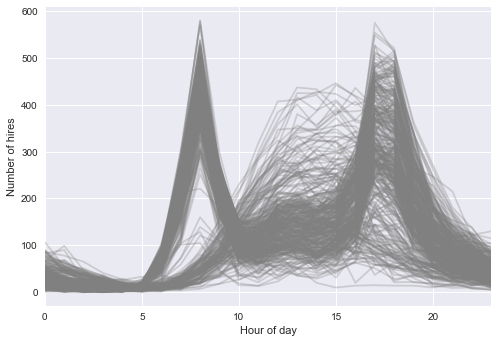

In [34]:
# Plot hourly rentals

pivoted.T.plot(legend=None, color='grey', alpha=0.3)
plt.xlabel('Hour of day')
plt.ylabel('Number of hires');

# Clustering days

The above plot suggests that there are two types of days: one following a commuting pattern, the other following a leasure pattern. To classify days into these two groups I proceed in two steps: I use PCA to reduce the number of dimensions in the data (the hourly data has 24 features) and then use a Gaussian Mixture Model to classify the low-dimension data into groups. If our intuition from the above graph is correct, then we'll end up with two groups from this proceedure.

### Use PCA to reduce dimensionality

In [35]:
# Create data

X = pivoted.values
X.shape

(360, 24)

Follow canonical scikit-learn process as described [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb)

In [36]:
from sklearn.decomposition import PCA # 1. Choose the model class

pca = PCA(n_components=0.9)           # 2. Instantiate the model with hyperparameter (retain 90% of variance)

pca.fit(X)                            # 3. Fit model to the data

Xpca = pca.transform(X)               # 4. Transform X to reduced number of dimensions

print('Original number of dimensions: {0}'.format(X.shape[1]))
print('Reduced number of dimensions: {0}'.format(Xpca.shape[1]))

Original number of dimensions: 24
Reduced number of dimensions: 2


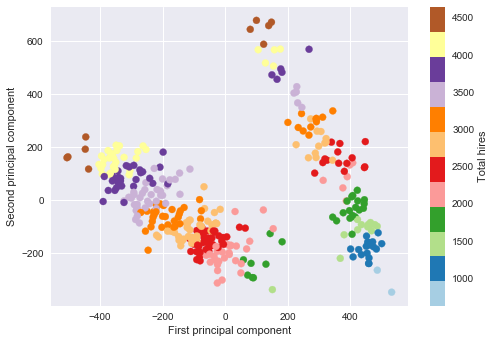

In [37]:
# Plot data

total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap="Paired")
plt.colorbar(label="Total hires")
plt.xlabel('First principal component')
plt.ylabel('Second principal component');

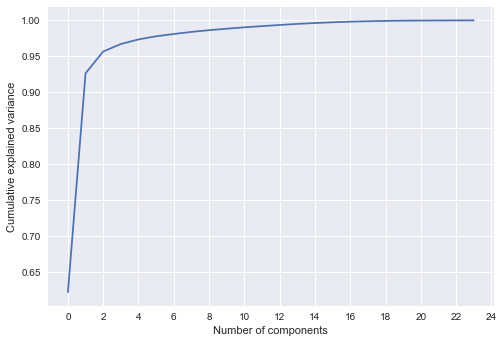

In [38]:
# Look at cumulatively explained variance as function of retained components

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 25, 2))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

We can see that the last six to eight don't relly add anything at all to the cumulatively explained variance. 
Looking at our dense line graph above this makes sense: for late evening and early morning hours there is very little variation in the number of hires, meaning the relative variance explained by these components is negligible. 

### Cluster data using GMM

Let's now group the data using GMM. It's already pretty clear from the PCA plot above that we'll end up with two groups. But we can use GMM to label each day.

In [39]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=2,
          covariance_type='full',
          random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)


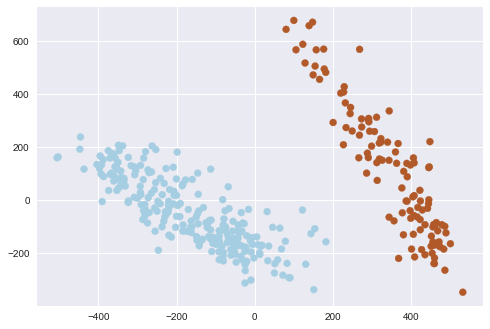

In [40]:
# Plot clusters

plt.scatter(Xpca[:,0], Xpca[:,1], c=cluster_label, cmap='Paired');

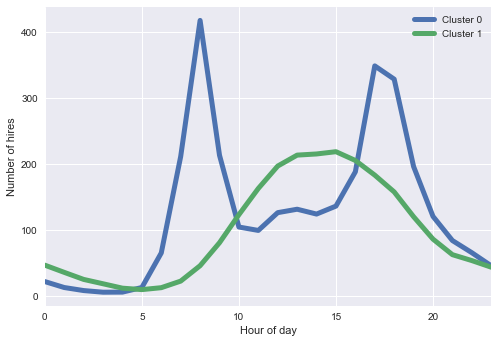

In [41]:
# Plot houry mean for each cluster

pivoted['cluster'] = cluster_label

hourly = pivoted.groupby('cluster').mean()

for i in range(2):
    hourly.loc[i].plot(linewidth=5, label=f'Cluster {i}')
plt.xlabel('Hour of day')
plt.ylabel('Number of hires')
plt.legend();

# Where are stations located

In [23]:
import geopandas as gpd
import descartes
import janitor
import pandas as pd
import pandas_flavor as pf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from toolbox.toolbox import get_stations_data
from toolbox.toolbox import get_borough_boundaries
from toolbox.toolbox import get_borough_profiles

@pf.register_dataframe_method
def keep_columns(df, column_names):
    return df[column_names]

In [21]:
# Load data and combine borough boundaries and profiles

stations = get_stations_data()
boundaries = get_borough_boundaries().set_index('name')
profiles = get_borough_profiles().set_index('area_name')

boroughs = boundaries.join(profiles)
boroughs.head()

,geometry,population,average_age,prop_working_age,happiness,anxiety,childhood_obesity_preval,labour_seats
name,,,,,,,,
Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",175400,37.1,67.2,7.4,3.3,16.9,4.2
Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",386500,37.0,64.9,7.2,3.3,24.5,57.1
Bromley,"POLYGON ((540373.600 157530.400, 540361.200 15...",327900,40.2,62.6,7.4,3.3,16,11.7
Hounslow,"POLYGON ((521975.800 178100.000, 521967.700 17...",274200,35.8,67.6,7.4,3.4,24.1,81.7
Ealing,"POLYGON ((510253.500 182881.600, 510249.900 18...",351600,36.2,66.8,7.3,3.6,23.8,76.8


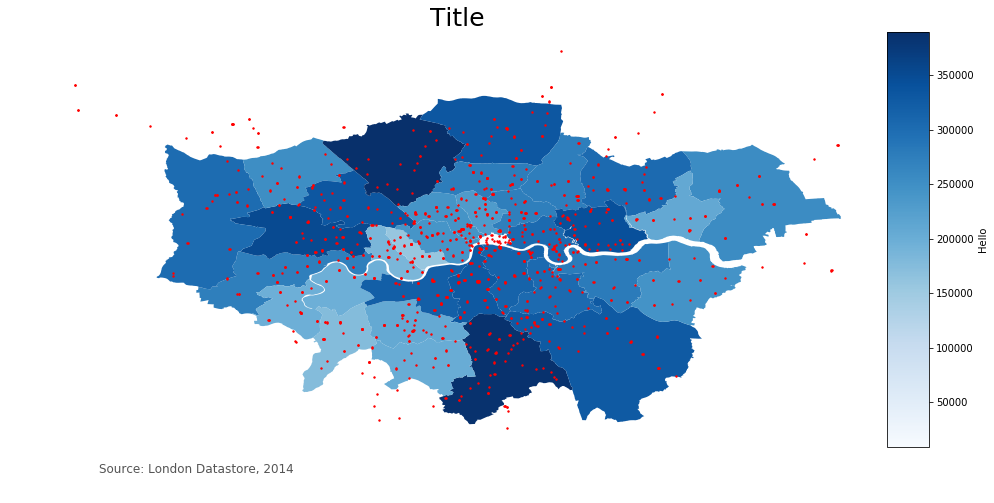

In [26]:
variable = 'population'

# Ensure that maps have the same crs
boroughs = boroughs.to_crs(stations.crs)

# Create borough map as base
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = boroughs.plot(column=variable, cmap='Blues', ax=ax, cax=cax,
                     legend=True, legend_kwds={'label':variable})

# Plot stations on top of base
stations.plot(ax=base, marker='o', color='red', markersize=2)

ax.axis('off')
ax.set_title('Title', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  
            fontsize=12, color='#555555',
            xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', );

Above figure is clearly unfinished, but going to leave this for now. The red dots, it seems, are actually tube stations rather than cycle hire spots. So will use charlie 1347 stuff to improve things.

Stuff from [charlie1347](https://github.com/charlie1347), based on [this](https://github.com/charlie1347/TfL_bikes/blob/master/TfL%20Bikes.ipynb) notebook.

In [ ]:
import requests
from xml.etree import ElementTree as ET
import pandas as pd

site = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

response = requests.get(site)
root = ET.fromstring(response.content)

id_list = [int(root[i][0].text) for i in range(0, len(root))]
name_list = [root[i][1].text for i in range(0, len(root))]
lat_list = [float(root[i][3].text) for i in range(0, len(root))]
lon_list = [float(root[i][4].text) for i in range(0, len(root))]
capacity_list = [int(root[i][12].text) for i in range(0, len(root))]

all_locs = pd.DataFrame(list(zip(name_list, id_list, lat_list, 
                                 lon_list, capacity_list)), columns = ["name","id","lat","lon","capacity"])

all_locs.to_csv('bike_point_locations_saved.csv', header=True, index=None)

print(all_locs.shape)
all_locs.head()

# Misc.

In [32]:
# Basic use of Beautiful soup from here: https://www.dataquest.io/blog/web-scraping-tutorial-python/

import requests
from bs4 import BeautifulSoup

url = 'https://cycling.data.tfl.gov.uk'

page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
[type(item) for item in list(soup.children)]

html = list(soup.children)[0]
[type(item) for item in list(html.children)]

[bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString]

In [31]:
# Save altair graph data locally to specified directory

def json_dir(data, data_dir='altair_data'):
    os.makedirs(data_dir, exist_ok=True)
    return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir='./data/altair_data')

DataTransformerRegistry.enable('json_dir')

In [32]:
# Use regex to search column names

list(df.filter(regex='logical|priority'))

['endstation_logical_terminal',
 'endstationpriority_id',
 'startstation_logical_terminal']

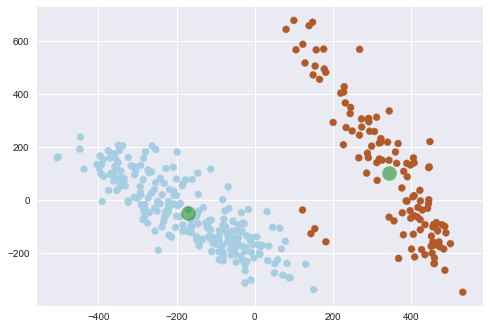

In [173]:
# Using K-means to classify data

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(Xpca)
km_clusters = kmeans.predict(Xpca)

plt.scatter(Xpca[:,0], Xpca[:,1], c=km_clusters, cmap='Paired')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], color='green', s=200, alpha=.5);